# Lecture 8: Errors in Inference / There is only one test!

## Today's Learning Goals

By the end of this lecture, you should be able to:

1. Define the two types of errors in hypothesis testing: I and II.
3. Explain the power of a test and understand it's relationship to the types of errors. 
4. Identify the importance of using the $p$-value to correctly draw statistical conclusions from hypothesis tests.
5. Highlight the consequences of double dipping when conducting statistical inference. 
6. Choose your estimator (mean, median, proportion, quantile, etc.) given an inferential question and the data at hand.
7. Craft hypotheses based on your question and estimator.
8. Choose a suitable test based on your hypotheses and the data at hand (not getting into which are more powerful, more like, which tests would be suitable).

## Loading `R` Packages and Plotting Code

In [2]:
library(cowplot)
library(ggplot2)
source("scripts/lecture_7_power_plots.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## 1. Errors in inference

### 1.1. Randomness everywhere!

In hypothesis testing, our test statistics involve randomness since they are based on random samples. Hence, we are at risk of committing errors in our test conclusions due to this randomness. These errors are embedded in hypothesis testing, so we try to control them (as probabilities!). Understanding the foundations of these errors is important since they are used in **power analysis**: the computation of the minimum sample size for any given inferential/causal study (to be seen in DSCI 554).

### 1.2. Types of Errors

There are two types of errors we can make when performing a hypothesis test: **type I error** and **type II error**. 

We commit a **type I error** if we reject $H_0$ when in fact, it is true (i.e., a false positive). In a hypothesis test, the type I error rate is represented by $\alpha$, the significance level. This is the main reason why we use the rule of $p\text{-value} < \alpha$ in our testing conclusion to reject or fail to reject $H_0$ (we want to control the type I error rate in our experiment). Mathematically, we can represent the type I error rate as the conditional probability 

$$ \alpha = P(\text{reject } H_0 | H_0 \text{ true}).$$ 


On the other hand, we commit a **type II error** if we fail to reject $H_0$, when in fact, it is **not** true (i.e., a false negative). We denote the type II error rate with the symbol $\beta$. This class of error has a particular role in our hypothesis test as it is the complement of the power of the test ($1-\beta$): our ability to reject the null hypothesis when it is false. Mathematically, we can represent the type II error rate as the conditional probability 

$$ \beta = P(\text{fail to reject } H_0 | H_0 \text{ false}).$$ 

We can summarize the types of conclusions that can be made in a hypothesis test using the following table:

|  |  **$H_0$ is true** |  **$H_0$ is not true** |
|:--------------------------------------------------------------------------------------------:|:------------------:|:----------------------:|
|                                   **Fail to reject $H_0$**                                   |       Correct      |      Type II Error     |
|                                       **Reject $H_0$**                                       |    Type I Error    |         Correct        |

To further understand the concept of type I and II errors, imagine you are the judge of a criminal trial and you need to make a decision on whether or not a defendant is guilty or not guilty of a crime. What are the potential types of errors in judgement you could make? Let's visualize this in a table. 

|  |  **Not guilty** |  **Guilty** |
|:--------------------------------------------------------------------------------------------:|:------------------:|:----------------------:|
|                                   **Verdict: Not guilty**                                   |       Correct      |      Type II Error     |
|                                       **Verdict: Guilty**                                       |    Type I Error    |         Correct        |

Thus, if the defendant is not guilty, the type I error would be finding them guilty (false positive). However, if the defendant is guilty, the type II error would be finding them not guilty (false negative). 

This example also highlights why we use the terminology "fail to reject $H_0$" instead of "accepting $H_0$" in hypothesis testing. We assume a defendant is innocent until proven guilty. When we reach a verdict of "not guilty", we are not concluding that the defendant is innocent, but rather that we do not have sufficient evidence that they are guilty. Similarly, we assume $H_0$ is true until we have evidence against it. That is, when we "fail to reject $H_0$, we are not accepting $H_0$, but we simply do not have sufficient evidence to reject $H_0$.

In an ideal situation, we have a hypothesis test with no error ($\alpha=0$ and $\beta=0$). However, the randomness from our samples makes this highly unlikely. The type I and type II error rates are inversely related, meaning that as one increases the other decreases. Typically, we fix the type I error rate by choosing $\alpha$ and try to minimize $\beta$ as much as possible. This is done because, in practice, making a type I error is usually considered more dangerous than making a type II error. 

### 1.3. The Power of a Test

The power of a test ($1 - \beta$) is the **true positive** rate. In other words, it is the probability of correctly rejecting $H_0$ when it should be rejected because it is false. 


To better understand the power of a test, let's consider an example. 

Consider a two-sample test to compare the compare the mean blood pressure between a treatment and control group in a clinical trial: 

$$ H_0: \mu_{trt}-\mu_{ctrl}=0 $$
$$ H_A: \mu_{trt}-\mu_{ctrl} \neq 0 $$

For $\alpha=0.05$ and sufficiently large $n$, imagine the null distribution as pictured below

> Note: For simplicity, we are assuming $SE_{\bar{x}_{trt}-\bar{x}_{ctrl}}=1$

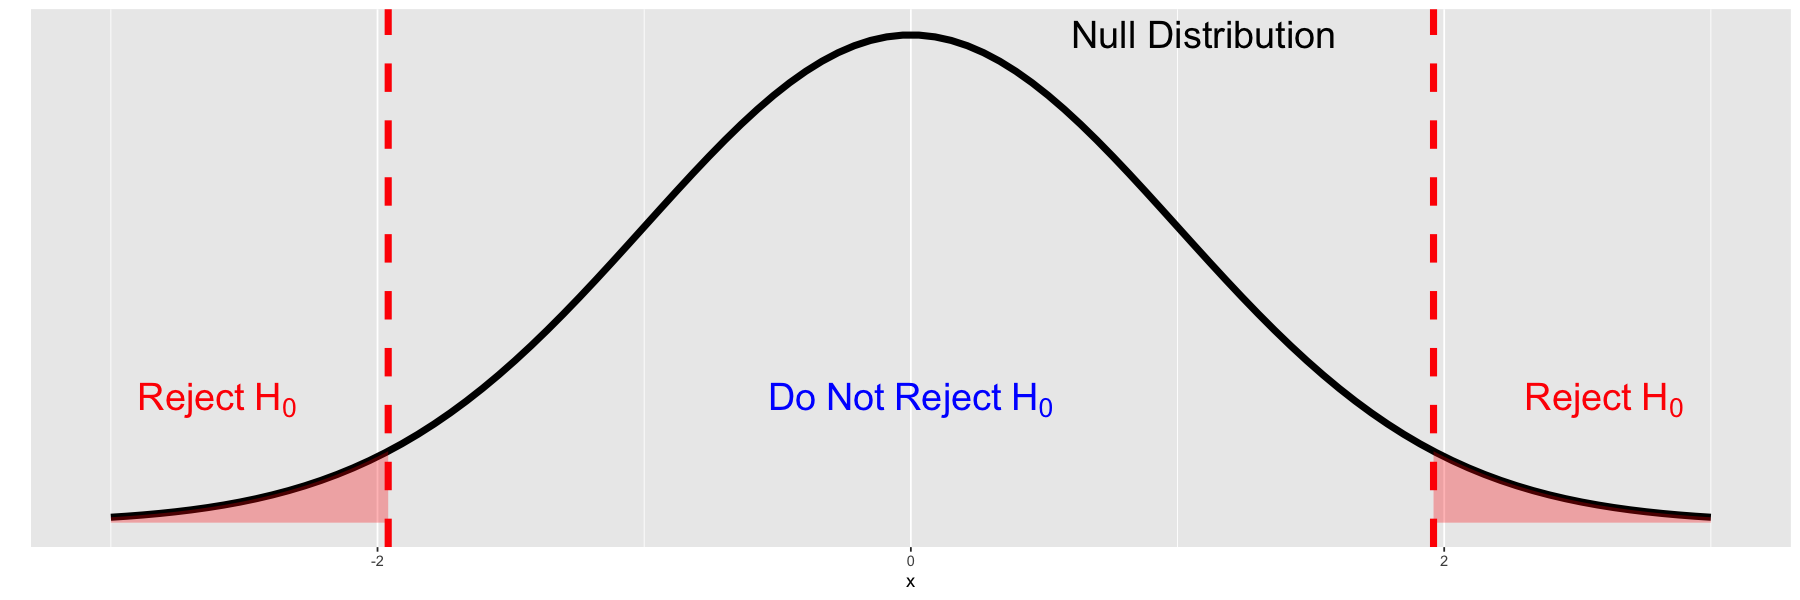

In [86]:
options(repr.plot.height = 5, repr.plot.width = 15)

null_dist <- ggplot(data = data.frame(x = c(-3, 3)), aes(x)) +
  stat_function(fun = dnorm, n = 100, args = list(mean = 0, sd = 1),lwd=2) + ylab("") +
  geom_area(stat = "function", fun = dnorm, fill = "red", xlim = c(-3, qnorm(0.025)),alpha=0.3) +
  geom_area(stat = "function", fun = dnorm, fill = "red", xlim = c(qnorm(0.975),3),alpha=0.3) +
  scale_y_continuous(breaks = NULL)+
  geom_vline(xintercept = c(qnorm(0.025), qnorm(0.975)),color="red",lty=2, lwd=2)+
  annotate(geom="text", x=-2.6, y=.1, parse=TRUE, label="Reject~H[0]",
           color="red", cex=8)+
  annotate(geom="text", x=2.6, y=.1, parse=TRUE, label="Reject~H[0]",
           color="red", cex=8)+
  annotate(geom="text", x=0, y=.1, parse=TRUE, label="Do~Not~Reject~H[0]",
           color="blue", cex=8)+
  annotate(geom="text", x=1.1, y=.4, label="Null Distribution",
           color="black",cex=8)



null_dist

Here, the <font color='red'>red</font> vertical dashed line is our threshold for the significance level $\alpha = 0.05$ (our tolerance level to commit Type I error). 

The power of the test is the probability of rejecting the null hypothesis, given that it is false. In other words, we will need to look at the distribution assuming the null hypothesis is false (i.e., $\mu_{trt}-\mu_{ctrl} \neq 0$). Based on random samples, suppose we computed the difference between the sample means and found it to be $\bar{x}_{trt}-\bar{x}_{ctrl} = -3$ mmHg. Let's look at the sampling distribution of $\bar{x}_{trt}-\bar{x}_{ctrl}$.

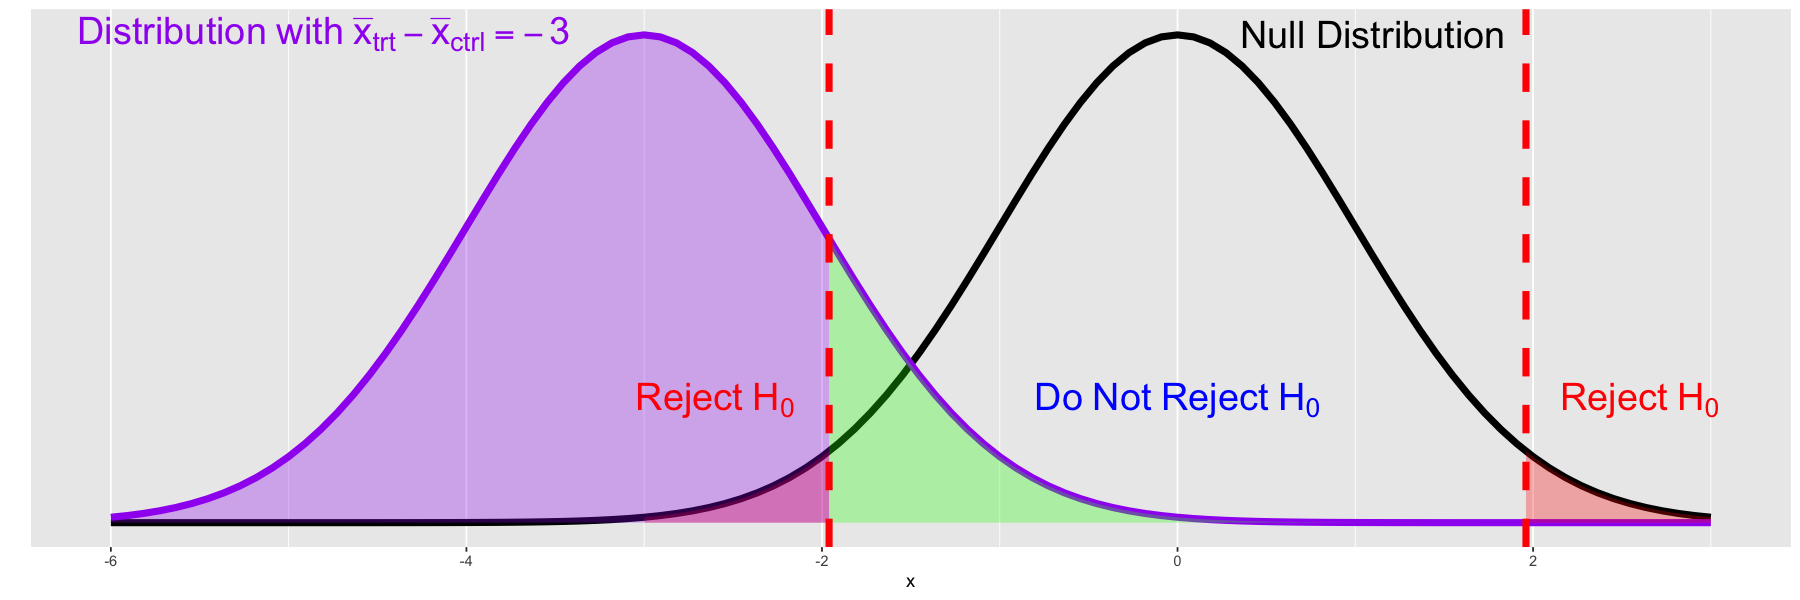

In [93]:
options(repr.plot.height = 5, repr.plot.width = 15)

dist_plot <- ggplot(data = data.frame(x = c(-6, 3)), aes(x)) +
  stat_function(fun = dnorm, n = 100, args = list(mean = 0, sd = 1),color="black",lwd=2) + ylab("") +
  stat_function(fun = dnorm, n = 100, args = list(mean = -3, sd = 1),color="purple",lwd=2) + ylab("") +
  geom_area(stat = "function", fun = dnorm, fill = "red", xlim = c(qnorm(0.975), 3),alpha=0.3) +
  geom_area(stat = "function", fun = dnorm, fill = "red", xlim = c(-3, qnorm(0.025)),alpha=0.3) +
  geom_area(stat = "function", fun = dnorm, args = list(mean = -3, sd = 1), fill = "green", xlim = c(qnorm(0.025),3),alpha=0.3) +
  geom_area(stat = "function", fun = dnorm, args = list(mean = -3, sd = 1), fill = "purple", xlim = c(-6, qnorm(0.025)),alpha=0.3) +
  scale_y_continuous(breaks = NULL)+
  geom_vline(xintercept = c(qnorm(0.025), qnorm(0.975)),color="red",lty=2, lwd=2)+
  annotate(geom="text", x=-2.6, y=.1, parse=TRUE, label="Reject~H[0]",
           color="red", cex=8)+
  annotate(geom="text", x=2.6, y=.1, parse=TRUE, label="Reject~H[0]",
           color="red", cex=8)+
  annotate(geom="text", x=0, y=.1,parse=TRUE, label="Do~Not~Reject~H[0]",
           color="blue", cex=8)+
  annotate(geom="text", x=1.1, y=.4, label="Null Distribution",
           color="black",cex=8)+
  annotate(geom="text", x = -4.8, y = 0.4, parse = TRUE,
           label = "Distribution~with~bar(x)[trt]-bar(x)[ctrl]==-3 ", color="purple",cex=8)


dist_plot

The shaded area in <font color='purple'>purple</font> represents the power, $1-\beta$. The shaded area in <font color='green'>green</font> represents the type II error rate, $\beta$. We can compute the power as 

In [81]:
pnorm(qnorm(0.025), mean=-3, sd=1)

[1] 0.8508384

There are adjustments that can be made that affect the power of a statistical test. The following are key factors that come into play when trying to maximize the power of the test:

- **Sample size:** The larger the sample size $n$, the larger the power of the test.

- **Significance level:** The larger the significance level $\alpha$, the larger the power of the test. Nevertheless, this implies a test more prone to committing type I error!

- **Effect size:** For example, the difference between the two group means. A larger effect size results in an increase in statistical power (although we can't usually control this in practice).  


Take a look at [this website](https://rpsychologist.com/d3/nhst/) to  visualize the relationship between power ($1 - \beta$), 
significance level ($\alpha$), sample size ($n$), and effect size. For instance, we can solve for the power and vary the significance level, sample size and effect size, noting that increasing these values leads to an increase in statistical power. 


### 1.4. Cohen's Effect Size

There are different ways to compute **effect size**, and a popular one is called **Cohen's effect size** $d$.

The way Cohen's effect size $d$ is computed also varies according to the type of test we are using. In the case of a one-sample $t$-test, it is

$$d = \frac{\bar{X} - \mu_0}{s},$$

where $\bar{X}$ is the sample mean, $\mu_0$ is the hypothesized mean value (i.e., $H_0: \mu = \mu_0$), and $s$ is the sample standard deviation.

Cohen's effect is a pretty convenient **effect size standardization** since the literature offers the following categories:

- **Small effect:** $d = 0.2$.
- **Medium effect:** $d = 0.5$.
- **Large effect:** $d = 0.8$.

The effect size helps researchers establish clinical significance, as opposed to just relying on statistical significance. 

## 2. The $p$-value

The $p$-value is an important point in hypothesis testing. Nonetheless, there are misunderstandings about it. 

Recall that the $p$-value is the probability of obtaining a test statistic just as extreme or more extreme than the observed test statistic under the null hypothesis. Intuitively, a small $p$-value indicates that your observed test statistic is highly unlikely under $H_0$.

### 2.1 $p$-hacking

The misuse of $p$-values in scientific research include cherry-picking data in order to get a "significant result" in a given statistical study. 


We have to avoid a practice known as **$p$-hacking** in which we perform many different tests on our data to obtain *any significant result* to publish. By doing this, multiple testing occurs, which inflates our type I error (unless we control it with some available correction such as the Bonferroni correction to be discussed in DSCI 554).

```{figure} img/multiple1.png
:height: 300px
:name: multiple_1

Image from [*https://xkcd.com/882/*](https://xkcd.com/882/).
```

```{figure} img/multiple2.png
:height: 900px
:name: multiple_2

Image from [*https://xkcd.com/882/*](https://xkcd.com/882/).
```

```{figure} img/multiple3.png
:height: 300px
:name: multiple_3

Image from [*https://xkcd.com/882/*](https://xkcd.com/882/).
```

### 2.2 Double Dipping

Throughout this course, we have been conducting statistical inference based on a given hypothesis or research question, but what if we don't have a clear statistical direction before we look at the data? 

Typically, we might be tempted to do some EDA to generate hypotheses of interest to investigate. However, if we look at all of the data and then use that same data to test our hypotheses it can lead to an issue in inference called **double dipping**. The consequence of this is our $p$-values are no longer controlling for the type I error rate, and results could be misleading. 

To avoid double dipping, we can split our data into training and testing sets and use the training data to perform EDA and generate hypotheses that can be evaluated on the test data. The motivation of this is similar to that of machine learning, where we want to avoid data leakage so we are not "cheating" and using the same data to train and test a model. However, for statistical inference, we know that sample size is important and having fewer observations can impact the power of a statistical test. Thus, we may want to consider different train test split ratios than in machine learning where the main objective is prediction (50:50 for example).

## 3. There is only one test!

But it can come in different flavours...

### 3.1. Simulation-based

```{figure} https://d33wubrfki0l68.cloudfront.net/c13657f5339f170a007f29a840739e0e10d55b32/a275c/images/ht.png
:height: 300px
:name: sim_hypothesis_b

Image from [*Ismay and Kim (2021)*](https://moderndive.com/9-hypothesis-testing.html).
```

### 3.2. Theory-based

```{figure} img/classical-test-framework.png
:height: 300px
:name: classical_hypothesis_b

Workflow of a theory-based hypothesis testing.
```

### 3.3. What varies between the different test flavours?

- Estimator.
- Hypotheses.
- Test statistic.
- Distribution under the null hypothesis.

### 3.4. Choosing your estimator given an inferential question and the data at hand

We have focused much in this second half of the course on estimating and performing hypothesis tests on the mean and proportions via classical theory-based methods; why?

This stems from Statistics' historical reliance on Mathematics due to computers not being powerful and accessible in the recent past. Hence, it was easier to work with these estimates mathematically compared to some others.

We have more options now (think of how easy it was to generate confidence intervals and perform hypothesis tests using bootstrapping and permutation), so we should be more open and considerate of the estimator we choose for estimation and hypothesis testing.

Let us now walk through various estimators and discuss when we might want to use these.

**Proportions**

```{admonition} Data type
Categorical
```

Proportions are useful when we care about the relative frequency of classes. For instance, is there any statistical difference in click-through-rates (CTRs) between two webpage versions (i.e., A/B testing)?

**Mean**

```{admonition} Data type
Continuous
```

When our distribution is not heavily skewed and/or has a long tail in one direction, the mean is a reasonable estimate of the central tendency of a distribution (i.e., where most values occur).

**Median**

```{admonition} Data type
Continuous
```

When our distribution is quite skewed or has long tails, the mean gets drawn out towards the tail. Thus, if we have such data and we really want to estimate the central tendency of the distribution, then the median is our friend! The median is not as sensitive to extreme values since it is mathematically the middle value of a distribution.

**Quantile**

```{admonition} Data type
Continuous
```

We want to estimate a quantile when we are interested in estimating the tail regions of distributions rather than the centre. Typical examples are the 1st, 5th, 10th, 90th, 95th, and 99th percentiles.

**Examples from [Takeuchi et al., 2006](http://ai.stanford.edu/~quocle/TakLeSeaSmo06.pdf) (authors of the non-parametric quantile regression, to be discussed in DSCI 562)**

- A device manufacturer may wish to know the 10% and 90% quantiles for some feature of the production process to tailor the process to cover 80% of the devices produced.

- For risk management and regulatory reporting purposes, a bank may need to estimate a lower bound on the changes in the value of its portfolio, which will hold with high probability.

**We might use other possible estimators:**

- Variance.
- Intercept (liner regression analysis).
- Slopes (linear regression analysis).
- Etc.

### 3.5. Hence, what is the take-home message?

We need to think deeply about what aspect of our distributions we care for the question we are asking. Then, we choose an estimator that does a decent job at describing that!

### 3.6. Setting up our hypotheses based on our question and estimator

After we have chosen our estimator, we can start crafting a suitable hypothesis for our inferential question. To do this, we need to ask ourselves the following questions:

1. **What is *not* interesting?** This becomes our null hypothesis. We almost always use an $=$ sign here. We specify that the parameter we are trying to estimate is *equal than* something (a value, or some other parameter).
2. **What is interesting?** This becomes our alternative hypothesis. We can do two-direction tests (i.e., $\neq$), and for those, we specify that the parameter we are trying to estimate is not equal to something (a value or some other parameter). If we are interested in a one-direction test, we use $>$ or $<$ to indicate this.

### 3.7. Choosing a suitable test flavour based on our hypotheses and the data at hand

Once our estimator is chosen, and our hypotheses are specified, the next step is to select a **suitable** test flavour. We have to emphasize the adjective **suitable** here, as often several tests are just fine for your analysis, and the differences you might observe between them could be practically negligible. 

The aim is not to find the "perfect" test, just a **suitable** one.

#### 3.7.1. What is a suitable test?

When exploring tests, we need to ask:

- Does the test work with the type of estimator we have chosen?
- Do we satisfy the test assumptions/conditions?

If the answer is "yes" to those two questions, we will likely have found a suitable test. Moreover, we can stop exploring and start doing our analysis.

```{important}
Some data exploration/analysis might be needed to answer the second question above.
```

#### 3.7.2. Where do we start searching?

There are different available flow-charts like this one:

```{figure} https://onishlab.colostate.edu/wp-content/uploads/2019/07/which_test_flowchart.png
:height: 350px
:name: test_flowchart

Image from [*Osborne Nishimura Lab (2019)*](https://onishlab.colostate.edu/summer-statistics-workshop-2019/).
```

Or useful websites such as the [Handbook of Biological Statistics](http://www.biostathandbook.com/testchoice.html) by John H. McDonald. Note these resources are basically toolboxes from which we need to select the right approach according to our data conditions.

These previous resources can be a good starting place, but some other tests are not listed there—for example, the permutation tests.

#### 3.7.3. What if we need a more specific test?

For example, searching for the "*test of independence for population means between 3 groups*" will lead us to Analysis of Variance (ANOVA), **to be covered in DSCI 554**. We can then read about the ANOVA **assumptions**, and then decide whether or not it fits our question and data in hand.

## 4. What is next?

- Putting this high-level, statistical maturity into practice in `lab4`.
- Maximum likelihood estimation.

## 5. Acknowledgements

- [Chapter 9 in Modern Dive](https://moderndive.com/9-hypothesis-testing.html)
- [Chapter 7 in OpenIntro Statistics](https://www.openintro.org/book/os/)
- [The missing question in supervised learning](https://github.com/vincenzocoia/vincenzocoia.github.io/blob/b9a5b5023e7d3dc0b135c032c7b1aa67376240db/_posts/2018-02-18-mean.md) blog post by Vincenzo Coia
- [Double Dipping]()